In [1]:
import time
start_time = time.time()

In [2]:
import logging
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

from dask.distributed import Client

import dcor

import lotka_volterra
import utils.caching
from utils.caching import cached, cached_batch, subscriptable
from utils.ksd import calculate_ksd
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.paths import FIGURES_PATH, GENERATED_DATA_PATH
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
figures_path = FIGURES_PATH

Directory where results of expensive calculations will be stored:

In [6]:
utils.caching.cache_dir = GENERATED_DATA_PATH

In [7]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [8]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36385 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36385/status,
Dashboard: http://127.0.0.1:36385/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45617,Workers: 4
Dashboard: http://127.0.0.1:36385/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:41581,Total threads: 4
Dashboard: http://127.0.0.1:40101/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:38207,


In [9]:
map_parallel = get_map_parallel(client)

In [10]:
n_chains = len(lotka_volterra.theta_inits)

In [11]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

Read-only input datasets:

In [12]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplemented

In [13]:
@subscriptable(n=n_chains)
@cached(read_only=True)
def rw_grads(i: int) -> np.ndarray:
    raise NotImplemented

In [14]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def validation_hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

In [15]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_4.npy


In [16]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_thinned_idx() -> list[np.ndarray]:
    raise NotImplemented

In [17]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_st_log_idx() -> list[np.ndarray]:
    raise NotImplemented

In [18]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_gf_simple_gaussian_idx() -> list[np.ndarray]:
    raise NotImplemented

In [19]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_gf_adjusted_gaussian_idx() -> list[np.ndarray]:
    raise NotImplemented

In [20]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_gf_t_idx() -> list[np.ndarray]:
    raise NotImplemented

In [21]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_gf_t2_idx() -> list[np.ndarray]:
    raise NotImplemented

# Energy distance comparison

In [22]:
def fit_quality(subsample, validation_sample_step=10):
    return np.sqrt(dcor.energy_distance(validation_sample[::validation_sample_step], subsample))

In [23]:
def naive_idx(n, m):
    return np.linspace(0, n - 1, m).astype(int)

In [24]:
thinned_size_series = []
thinned_size_series.append(np.linspace(5, 100, 50).astype(int))
thinned_size_series.append(np.linspace(100, n_points_calculate, 200).astype(int))
thinned_sizes = np.concatenate(thinned_size_series)

In [25]:
@cached(recalculate=recalculate, persist=True)
def rw_energy_distance(i_chain, idx_name) -> np.ndarray:
    sample = rw_samples[i_chain]
    idx = globals()[idx_name][i_chain]
    energy_distances = np.fromiter((fit_quality(sample[idx[:thinned_size]]) for thinned_size in thinned_sizes), float)
    return np.stack([thinned_sizes, energy_distances], axis=1)

In [26]:
@cached(recalculate=recalculate, persist=True)
def rw_energy_distance_naive(i_chain) -> np.ndarray:
    sample = rw_samples[i_chain]
    n = sample.shape[0]
    energy_distances = np.fromiter((fit_quality(sample[naive_idx(n, thinned_size)]) for thinned_size in thinned_sizes), float)
    return np.stack([thinned_sizes, energy_distances], axis=1)

In [27]:
indices1 = {
    'rw_thinned_idx': 'Stein: linear space',
    'rw_st_log_idx': 'Stein log space',
    'rw_naive': 'Naïve',
}

In [28]:
def get_indices(name):
    if name == 'rw_naive':
        return rw_energy_distance_naive
    else:
        return lambda i: rw_energy_distance(i, name)

In [29]:
def plot_comparison(result_function, entries, y_label, y_scale=None):
    fig = plt.figure(figsize=(15, 9), constrained_layout=True)
    axs = centered_subplots(fig, [3, 2])
    for j in range(len(lotka_volterra.theta_inits)):
        for idx_name, label in entries.items():
            res = result_function(idx_name)(j)
            axs[j].plot(res[:, 0], res[:, 1], label=label);
        axs[j].set_xlabel('Thinned sample size');
        axs[j].set_ylabel(y_label);
        axs[j].set_title(f'Chain {j + 1}');
        axs[j].legend();
        axs[j].set_xscale('log');
        if y_scale is not None:
            axs[j].set_yscale(y_scale);
    return fig

DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_0_rw_thinned_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_energy_distance_0_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_0_rw_st_log_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_energy_distance_0_rw_st_log_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_naive_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_energy_distance_naive_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_1_rw_thinned_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_energy_distance_1_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_1_rw_st_log_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_energy_distance_1_rw_st_log_idx.npy
DEBUG:utils.caching:Reading

CPU times: user 2.96 s, sys: 377 ms, total: 3.33 s
Wall time: 3.55 s


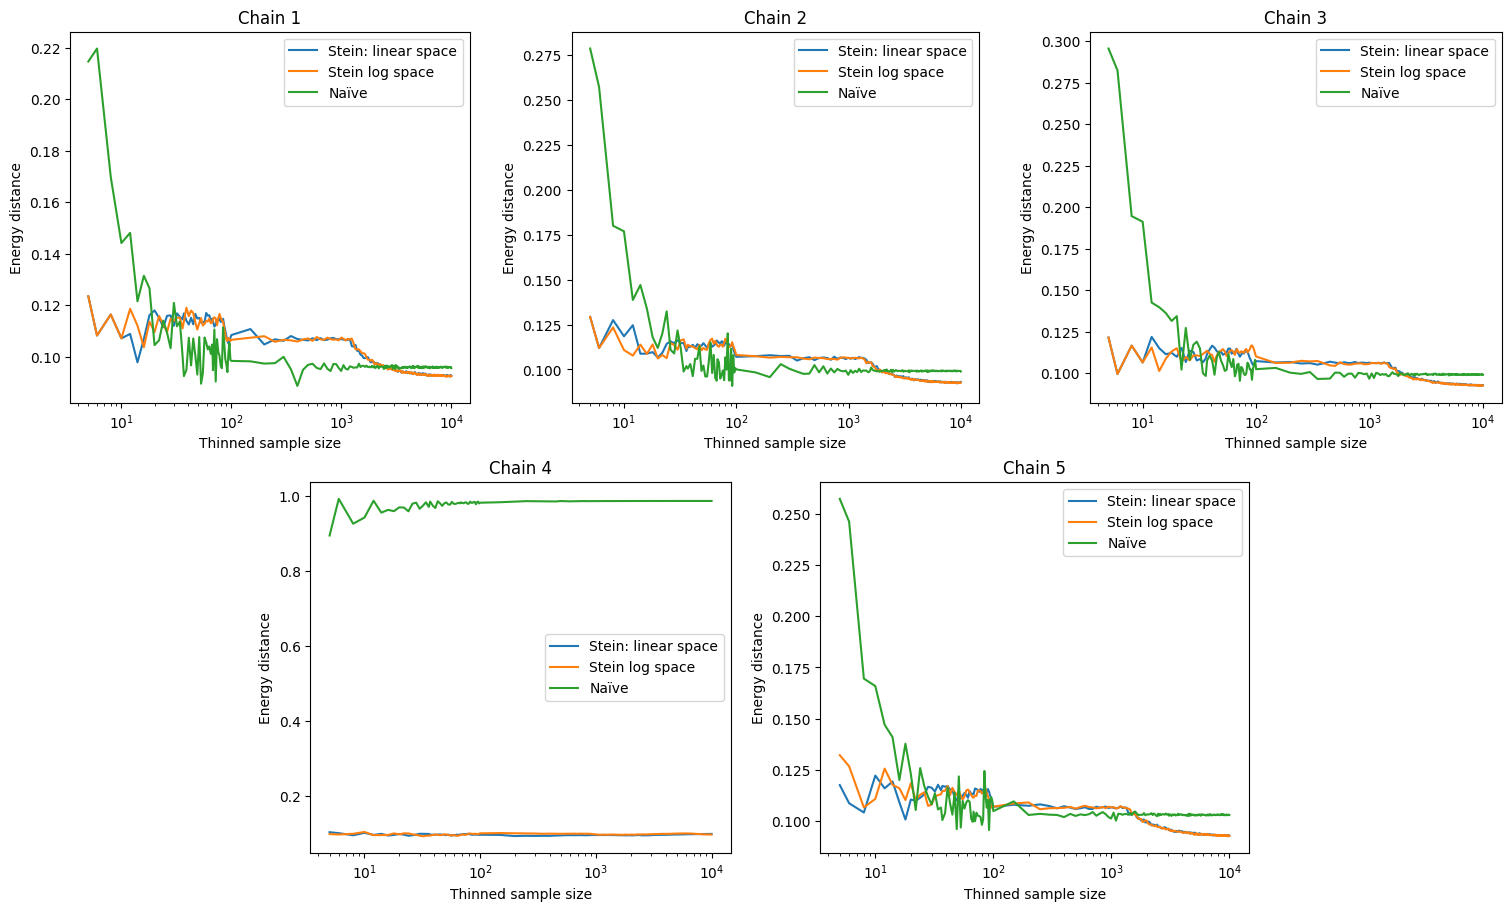

In [30]:
%%time
fig = plot_comparison(get_indices, indices1, y_label='Energy distance')
fig.savefig(figures_path / 'lotka-volterra-stein-thinning-energy-distance.pdf');

In [31]:
@cached(recalculate=recalculate, persist=True)
def rw_ksd(i_chain, idx_name) -> np.ndarray:
    sample = rw_samples[i_chain]
    gradient = rw_grads[i_chain]
    idx = globals()[idx_name][i_chain]
    distances = calculate_ksd(sample, gradient, idx)[thinned_sizes - 1]
    return np.stack([thinned_sizes, distances], axis=1)

In [32]:
@cached(recalculate=recalculate, persist=True)
def rw_ksd_naive(i_chain) -> np.ndarray:
    sample = rw_samples[i_chain]
    gradient = rw_grads[i_chain]
    n = sample.shape[0]
    distances = np.fromiter(
        (calculate_ksd(sample, gradient, naive_idx(n, thinned_size))[-1] for thinned_size in thinned_sizes),
        float,
    )
    return np.stack([thinned_sizes, distances], axis=1)

In [33]:
def get_indices_ksd(name):
    if name == 'rw_naive':
        return rw_ksd_naive
    else:
        return lambda i: rw_ksd(i, name)

DEBUG:utils.caching:Reading from disk cache: rw_ksd_0_rw_thinned_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_0_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_0_rw_st_log_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_0_rw_st_log_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_naive_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_naive_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_1_rw_thinned_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_1_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_1_rw_st_log_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_1_rw_st_log_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_naive_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_na

CPU times: user 3.96 s, sys: 386 ms, total: 4.35 s
Wall time: 5.65 s


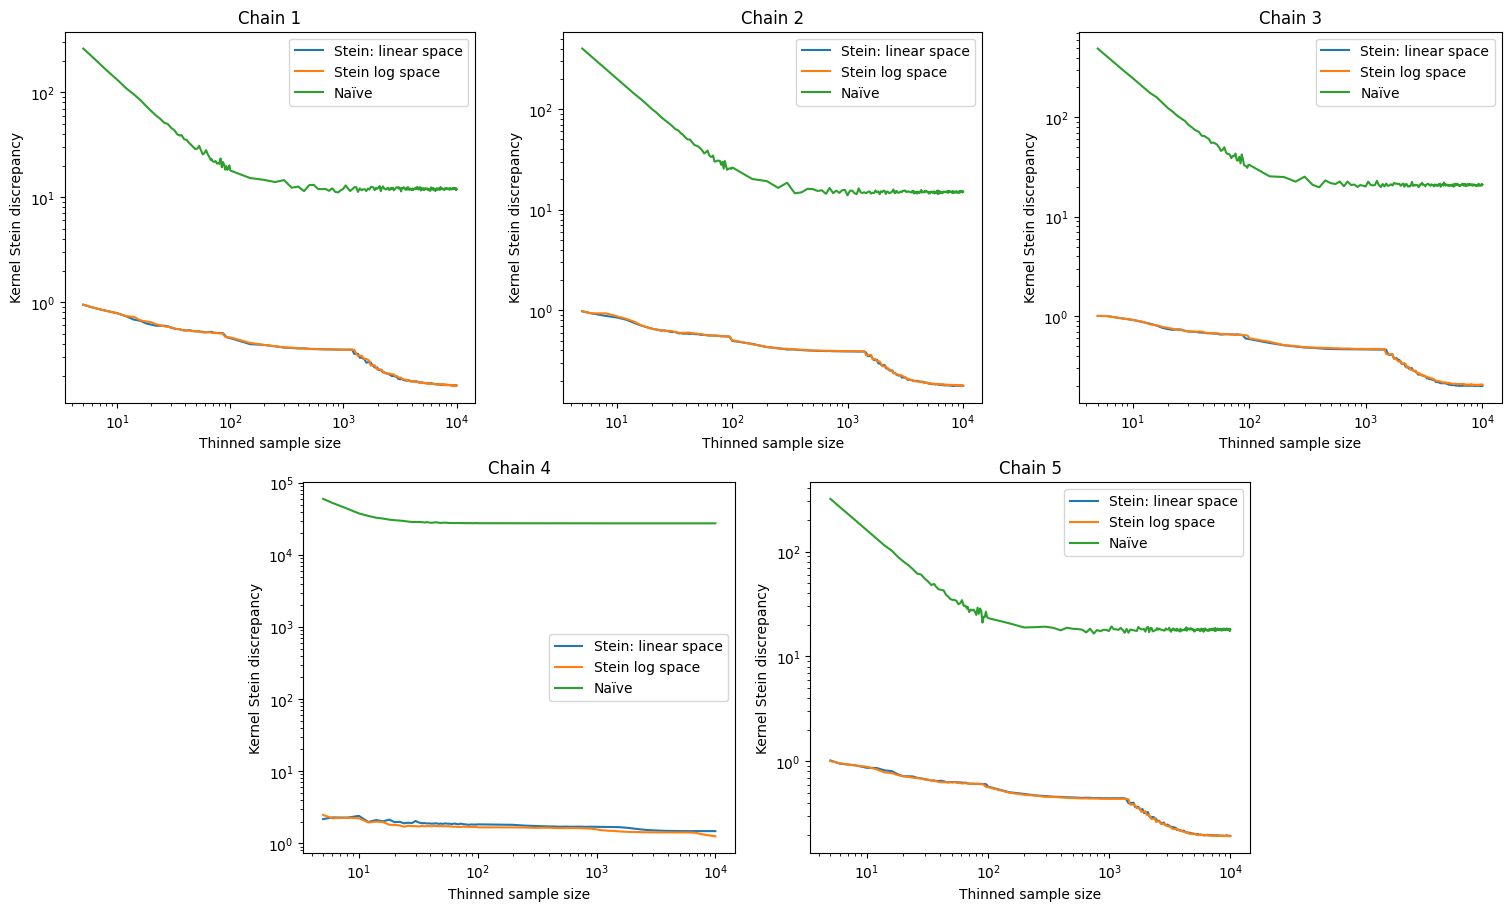

In [34]:
%%time
fig = plot_comparison(get_indices_ksd, indices1, y_label='Kernel Stein discrepancy', y_scale='log')
fig.savefig(figures_path / 'lotka-volterra-stein-thinning-ksd.pdf');

In [35]:
indices2 = {
    'rw_naive': 'Naïve',
    'rw_st_log_idx': 'Stein',
    'rw_gf_simple_gaussian_idx': 'Gradient-free: simple Gaussian',
    #'rw_gf_adjusted_gaussian_idx': 'Gradient-free adjusted Gaussian',
    #'rw_gf_t_idx': 'Gradient-free: t optimised',
    #'rw_gf_t2_idx': 'Gradient-free: t fixed',
}

DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_0_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_energy_distance_0_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_1_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_energy_distance_1_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_2_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_energy_distance_2_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_3_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_energy_distance_3_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_4_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Read

CPU times: user 2.45 s, sys: 317 ms, total: 2.76 s
Wall time: 3.7 s


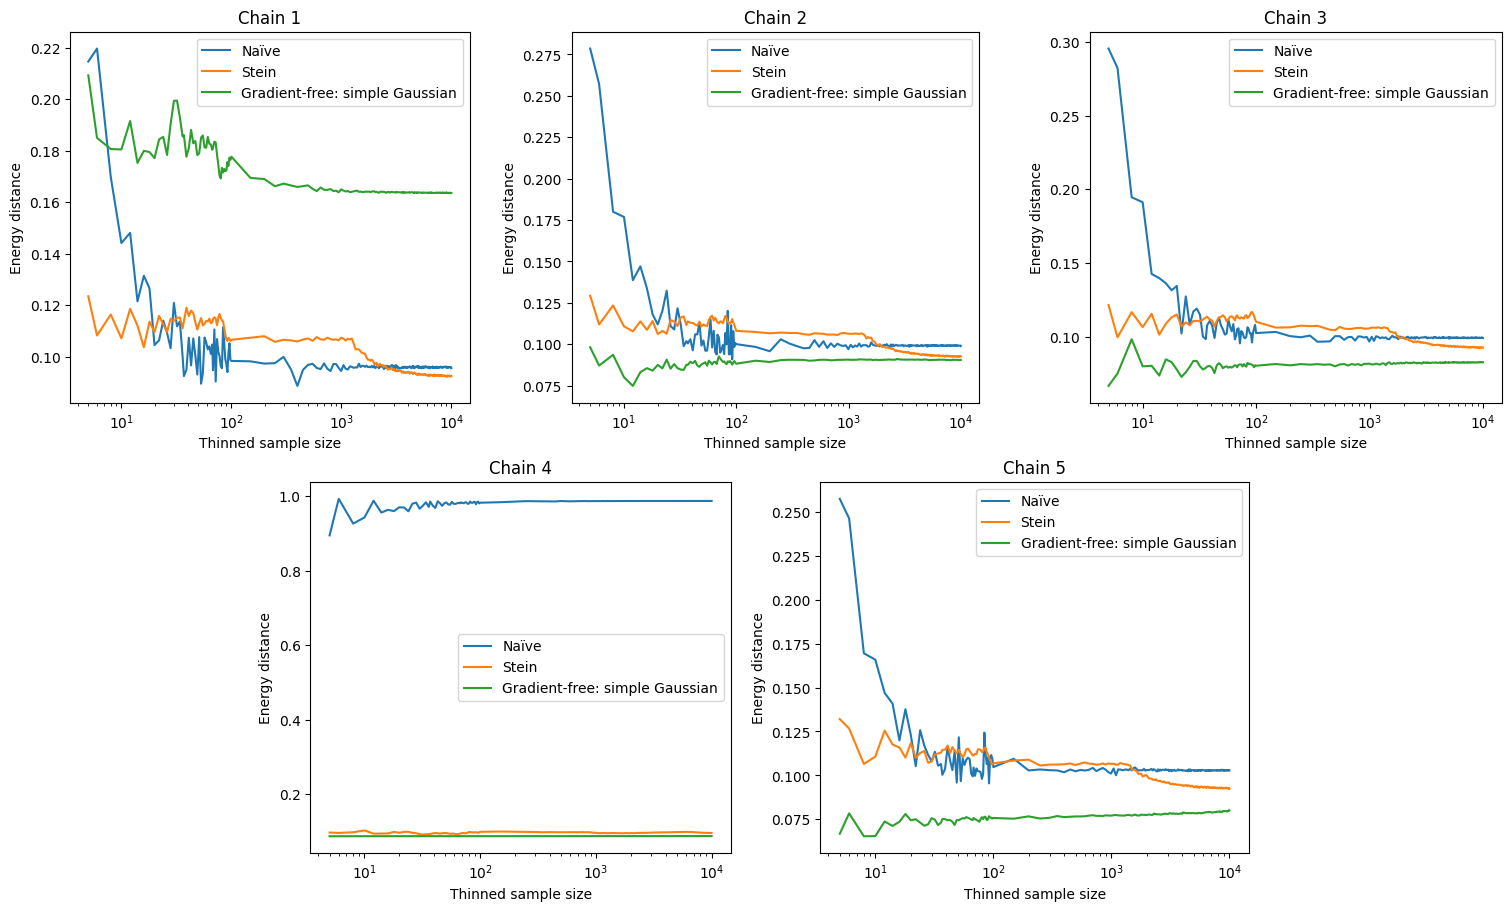

In [36]:
%%time
fig = plot_comparison(get_indices, indices2, y_label='Energy distance')
fig.savefig(figures_path / 'lotka-volterra-gf-thinning-energy-distance.pdf');

DEBUG:utils.caching:Reading from disk cache: rw_ksd_0_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_0_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_1_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_1_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_2_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_2_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_3_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_3_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_4_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_ksd_4_rw_gf_simple_gaussian_idx.npy


CPU times: user 3.81 s, sys: 539 ms, total: 4.35 s
Wall time: 4.22 s


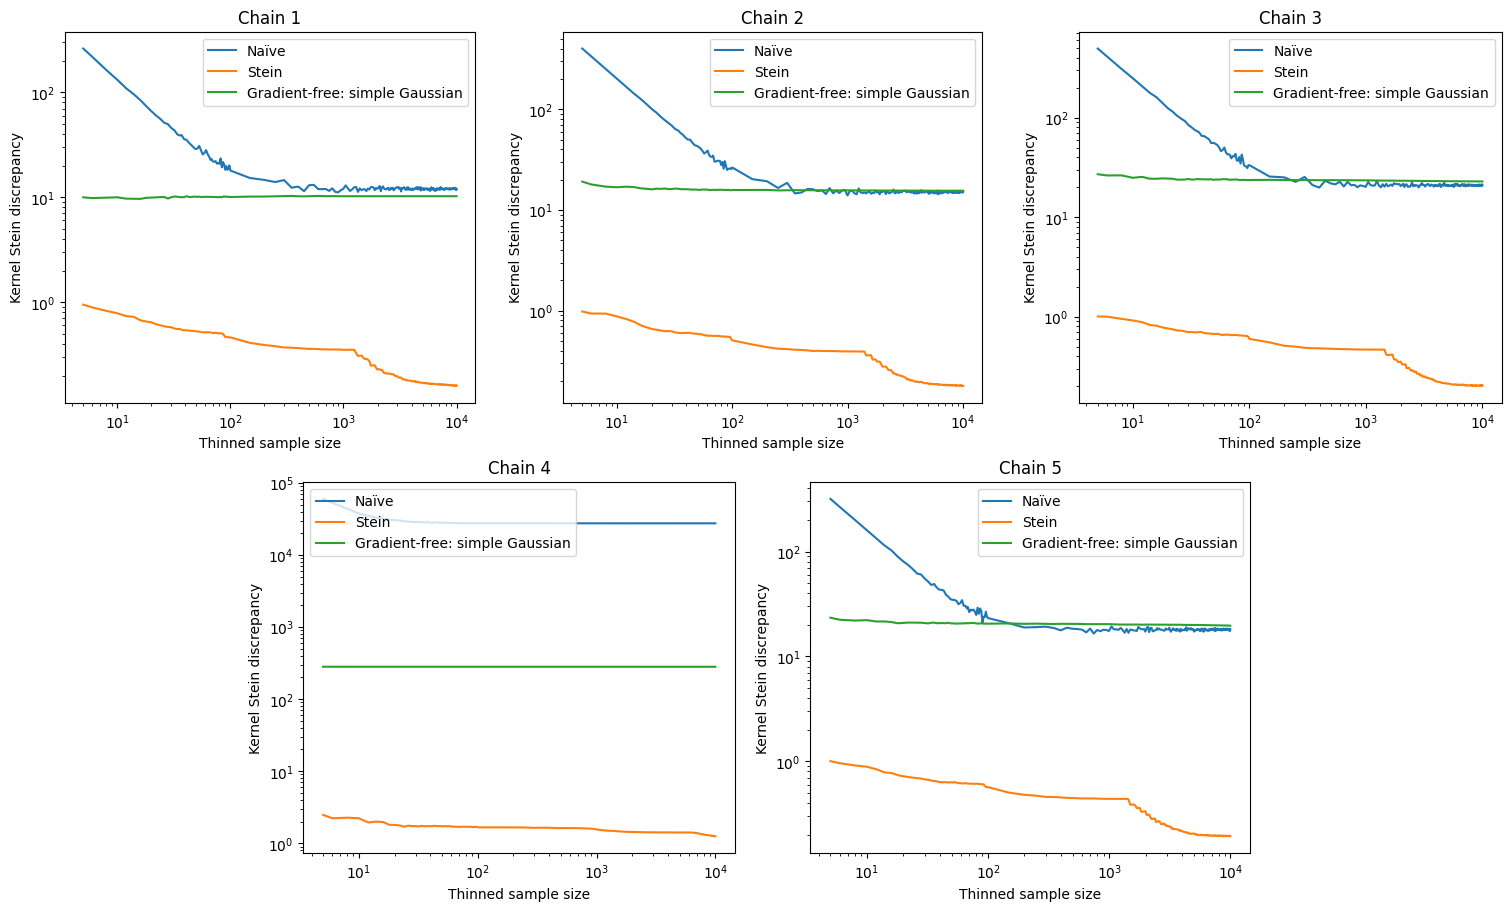

In [37]:
%%time
fig = plot_comparison(get_indices_ksd, indices2, y_label='Kernel Stein discrepancy', y_scale='log')
fig.savefig(figures_path / 'lotka-volterra-gf-thinning-ksd.pdf');

Notebook execution took:

In [38]:
time.time() - start_time

59.57460403442383